# 小批量随机梯度下降
:label:`sec_minibatch_sgd`

到目前为止，我们在基于梯度的学习方法中遇到了两个极端情况：
 :numref:`sec_gd`中使用完整数据集来计算梯度并更新参数，
 :numref:`sec_sgd`中一次处理一个训练样本来取得进展。
二者各有利弊：每当数据非常相似时，梯度下降并不是非常“数据高效”。
而由于CPU和GPU无法充分利用向量化，随机梯度下降并不特别“计算高效”。
这暗示了两者之间可能有折中方案，这便涉及到*小批量随机梯度下降*（minibatch gradient descent）。

## 向量化和缓存

使用小批量的决策的核心是计算效率。
当考虑与多个GPU和多台服务器并行处理时，这一点最容易被理解。在这种情况下，我们需要向每个GPU发送至少一张图像。
有了每台服务器8个GPU和16台服务器，我们就能得到大小为128的小批量。

当涉及到单个GPU甚至CPU时，事情会更微妙一些：
这些设备有多种类型的内存、通常情况下多种类型的计算单元以及在它们之间不同的带宽限制。
例如，一个CPU有少量寄存器（register），L1和L2缓存，以及L3缓存（在不同的处理器内核之间共享）。
随着缓存的大小的增加，它们的延迟也在增加，同时带宽在减少。
可以说，处理器能够执行的操作远比主内存接口所能提供的多得多。

首先，具有16个内核和AVX-512向量化的2GHz CPU每秒可处理高达$2 \cdot 10^9 \cdot 16 \cdot 32 = 10^{12}$个字节。
同时，GPU的性能很容易超过该数字100倍。
而另一方面，中端服务器处理器的带宽可能不超过100Gb/s，即不到处理器满负荷所需的十分之一。
更糟糕的是，并非所有的内存入口都是相等的：内存接口通常为64位或更宽（例如，在最多384位的GPU上）。
因此读取单个字节会导致由于更宽的存取而产生的代价。

其次，第一次存取的额外开销很大，而按序存取（sequential access）或突发读取（burst read）相对开销较小。
有关更深入的讨论，请参阅此[维基百科文章](https://en.wikipedia.org/wiki/Cache_hierarchy)。

减轻这些限制的方法是使用足够快的CPU缓存层次结构来为处理器提供数据。
这是深度学习中批量处理背后的推动力。
举一个简单的例子：矩阵-矩阵乘法。
比如$\mathbf{A} = \mathbf{B}\mathbf{C}$，我们有很多方法来计算$\mathbf{A}$。例如，我们可以尝试以下方法：

1. 我们可以计算$\mathbf{A}_{ij} = \mathbf{B}_{i,:} \mathbf{C}_{:,j}^\top$，也就是说，我们可以通过点积进行逐元素计算。
1. 我们可以计算$\mathbf{A}_{:,j} = \mathbf{B} \mathbf{C}_{:,j}^\top$，也就是说，我们可以一次计算一列。同样，我们可以一次计算$\mathbf{A}$一行$\mathbf{A}_{i,:}$。
1. 我们可以简单地计算$\mathbf{A} = \mathbf{B} \mathbf{C}$。
1. 我们可以将$\mathbf{B}$和$\mathbf{C}$分成较小的区块矩阵，然后一次计算$\mathbf{A}$的一个区块。

如果我们使用第一个选择，每次我们计算一个元素$\mathbf{A}_{ij}$时，都需要将一行和一列向量复制到CPU中。
更糟糕的是，由于矩阵元素是按顺序对齐的，因此当从内存中读取它们时，我们需要访问两个向量中许多不相交的位置。
第二种选择相对更有利：我们能够在遍历$\mathbf{B}$的同时，将列向量$\mathbf{C}_{:,j}$保留在CPU缓存中。
它将内存带宽需求减半，相应地提高了访问速度。
第三种选择表面上是最可取的，然而大多数矩阵可能不能完全放入缓存中。
第四种选择提供了一个实践上很有用的方案：我们可以将矩阵的区块移到缓存中然后在本地将它们相乘。
让我们来看看这些操作在实践中的效率如何。

除了计算效率之外，Python和深度学习框架本身带来的额外开销也是相当大的。
回想一下，每次我们执行代码时，Python解释器都会向深度学习框架发送一个命令，要求将其插入到计算图中并在调度过程中处理它。
这样的额外开销可能是非常不利的。
总而言之，我们最好用向量化（和矩阵）。


In [2]:
import numpy as np
import time

class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [12]:
%matplotlib inline
import numpy as np
import torch
from torch import nn
# from d2l import torch as d2l

timer = Timer()
A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)

按元素分配只需遍历分别为$\mathbf{B}$和$\mathbf{C}$的所有行和列，即可将该值分配给$\mathbf{A}$。


In [13]:
# 逐元素计算A=BC
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = torch.dot(B[i, :], C[:, j])
timer.stop()

0.6175272464752197

更快的策略是执行按列分配。


In [14]:
# 逐列计算A=BC
timer.start()
for j in range(256):
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()

0.02301478385925293

最有效的方法是在一个区块中执行整个操作。让我们看看它们各自的操作速度是多少。


In [15]:
# 一次性计算A=BC
timer.start()
A = torch.mm(B, C)
timer.stop()

# 乘法和加法作为单独的操作（在实践中融合）
gigaflops = [2/i for i in timer.times]
print(f'performance in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

performance in Gigaflops: element 3.239, column 86.901, full 1993.490


## 小批量

:label:`sec_minibatches`

之前我们会理所当然地读取数据的*小批量*，而不是观测单个数据来更新参数，现在简要解释一下原因。
处理单个观测值需要我们执行许多单一矩阵-矢量（甚至矢量-矢量）乘法，这耗费相当大，而且对应深度学习框架也要巨大的开销。
这既适用于计算梯度以更新参数时，也适用于用神经网络预测。
也就是说，每当我们执行$\mathbf{w} \leftarrow \mathbf{w} - \eta_t \mathbf{g}_t$时，消耗巨大。其中

$$\mathbf{g}_t = \partial_{\mathbf{w}} f(\mathbf{x}_{t}, \mathbf{w}).$$

我们可以通过将其应用于一个小批量观测值来提高此操作的*计算*效率。
也就是说，我们将梯度$\mathbf{g}_t$替换为一个小批量而不是单个观测值

$$\mathbf{g}_t = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w}).$$

让我们看看这对$\mathbf{g}_t$的统计属性有什么影响：由于$\mathbf{x}_t$和小批量$\mathcal{B}_t$的所有元素都是从训练集中随机抽出的，因此梯度的期望保持不变。
另一方面，方差显著降低。
由于小批量梯度由正在被平均计算的$b := |\mathcal{B}_t|$个独立梯度组成，其标准差降低了$b^{-\frac{1}{2}}$。
这本身就是一件好事，因为这意味着更新与完整的梯度更接近了。

直观来说，这表明选择大型的小批量$\mathcal{B}_t$将是普遍可行的。
然而，经过一段时间后，与计算代价的线性增长相比，标准差的额外减少是微乎其微的。
在实践中我们选择一个足够大的小批量，它可以提供良好的计算效率同时仍适合GPU的内存。
下面，我们来看看这些高效的代码。
在里面我们执行相同的矩阵-矩阵乘法，但是这次我们将其一次性分为64列的“小批量”。


In [16]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
timer.stop()
print(f'performance in Gigaflops: block {2 / timer.times[3]:.3f}')

performance in Gigaflops: block 499.828


显而易见，小批量上的计算基本上与完整矩阵一样有效。
需要注意的是，在 :numref:`sec_batch_norm`中，我们使用了一种在很大程度上取决于小批量中的方差的正则化。
随着后者增加，方差会减少，随之而来的是批量规范化带来的噪声注入的好处。
关于实例，请参阅 :cite:`Ioffe.2017`，了解有关如何重新缩放并计算适当项目。

## 读取数据集

让我们来看看如何从数据中有效地生成小批量。
下面我们使用NASA开发的测试机翼的数据集[不同飞行器产生的噪声](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise)来比较这些优化算法。
为方便起见，我们只使用前$1,500$样本。
数据已作预处理：我们移除了均值并将方差重新缩放到每个坐标为$1$。


In [17]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

def download_file(url, filename):
    """下载文件"""
    import urllib.request
    import os
    
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filename)
    else:
        print(f"{filename} already exists.")
    return filename

def load_array(data_arrays, batch_size, is_train=True):
    """构建PyTorch数据迭代器"""
    dataset = TensorDataset(*data_arrays)
    return DataLoader(dataset, batch_size, shuffle=is_train)

# 数据集信息
DATA_HUB = {}
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB['airfoil'] = (DATA_URL + 'airfoil_self_noise.dat',
                       '76e5be1548fd8222e5074cf0faae75edff8cf93f')

def get_data_ch11(batch_size=10, n=1500):
    """
    获取空气动力学数据集
    
    参数:
    - batch_size: 批量大小
    - n: 使用的样本数量
    
    返回:
    - data_iter: 数据迭代器
    - feature_dim: 特征维度
    """
    # 下载数据
    url, sha1_hash = DATA_HUB['airfoil']
    filename = 'airfoil_self_noise.dat'
    download_file(url, filename)
    
    # 加载数据
    data = np.genfromtxt(filename, dtype=np.float32, delimiter='\t')
    
    # 数据标准化：移除均值并缩放方差为1
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    
    # 取前n个样本，特征为前几列，标签为最后一列
    features = torch.from_numpy(data[:n, :-1])
    labels = torch.from_numpy(data[:n, -1])
    
    # 创建数据加载器
    data_iter = load_array((features, labels), batch_size, is_train=True)
    
    # 返回数据迭代器和特征维度
    return data_iter, data.shape[1]-1

# 测试函数是否正常工作
if __name__ == "__main__":
    # 测试获取数据
    batch_size = 10
    data_iter, feature_dim = get_data_ch11(batch_size)
    
    # 查看一批数据
    for X, y in data_iter:
        print(f"Batch features shape: {X.shape}")
        print(f"Batch labels shape: {y.shape}")
        break
        
    print(f"Feature dimension: {feature_dim}")

Batch features shape: torch.Size([10, 5])
Batch labels shape: torch.Size([10])
Feature dimension: 5


In [6]:
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

#@save
def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1

## 从零开始实现

 :numref:`sec_linear_scratch`一节中已经实现过小批量随机梯度下降算法。
我们在这里将它的输入参数变得更加通用，主要是为了方便本章后面介绍的其他优化算法也可以使用同样的输入。
具体来说，我们添加了一个状态输入`states`并将超参数放在字典`hyperparams`中。
此外，我们将在训练函数里对各个小批量样本的损失求平均，因此优化算法中的梯度不需要除以批量大小。


In [18]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

下面实现一个通用的训练函数，以方便本章后面介绍的其他优化算法使用。
它初始化了一个线性回归模型，然后可以使用小批量随机梯度下降以及后续小节介绍的其他算法来训练模型。


In [19]:
from IPython import display
import torch

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        
        # 替换 d2l.use_svg_display()
        import matplotlib.pyplot as plt
        plt.rcParams['figure.figsize'] = figsize
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 替换 d2l.set_axes，使用 lambda 函数直接配置参数
        self.config_axes = lambda: self._set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def _set_axes(self, ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """设置坐标轴标签、范围和比例"""
        import matplotlib.pyplot as plt
        # 设置坐标轴标签
        if xlabel:
            ax.set_xlabel(xlabel)
        if ylabel:
            ax.set_ylabel(ylabel)
        # 设置坐标轴范围
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        # 设置坐标轴比例
        if xscale:
            ax.set_xscale(xscale)
        if yscale:
            ax.set_yscale(yscale)
        # 设置图例
        if legend:
            ax.legend(legend)
        # 添加网格
        ax.grid(True)

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2


class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [20]:
#@save
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # 初始化模型
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: linreg(X, w, b), squared_loss
    # 训练模型
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

让我们来看看批量梯度下降的优化是如何进行的。
这可以通过将小批量设置为1500（即样本总数）来实现。
因此，模型参数每个迭代轮数只迭代一次。


loss: 0.245, 0.018 sec/epoch


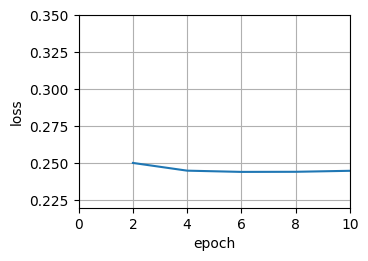

In [21]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(
        sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

当批量大小为1时，优化使用的是随机梯度下降。
为了简化实现，我们选择了很小的学习率。
在随机梯度下降的实验中，每当一个样本被处理，模型参数都会更新。
在这个例子中，这相当于每个迭代轮数有1500次更新。
可以看到，目标函数值的下降在1个迭代轮数后就变得较为平缓。
尽管两个例子在一个迭代轮数内都处理了1500个样本，但实验中随机梯度下降的一个迭代轮数耗时更多。
这是因为随机梯度下降更频繁地更新了参数，而且一次处理单个观测值效率较低。


loss: 0.243, 0.032 sec/epoch


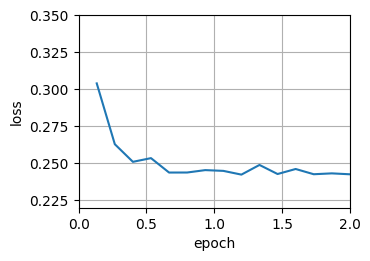

In [22]:
sgd_res = train_sgd(0.005, 1)

最后，当批量大小等于100时，我们使用小批量随机梯度下降进行优化。
每个迭代轮数所需的时间比随机梯度下降和批量梯度下降所需的时间短。


loss: 0.246, 0.002 sec/epoch


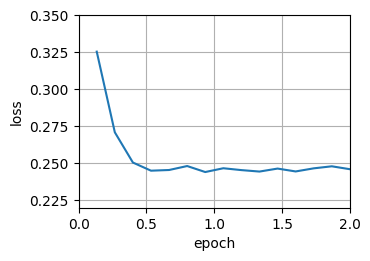

In [23]:
mini1_res = train_sgd(.4, 100)

将批量大小减少到10，每个迭代轮数的时间都会增加，因为每批工作负载的执行效率变得更低。


loss: 0.244, 0.005 sec/epoch


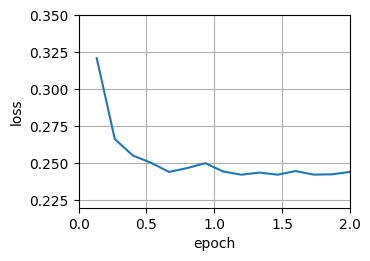

In [24]:
mini2_res = train_sgd(.05, 10)

现在我们可以比较前四个实验的时间与损失。
可以看出，尽管在处理的样本数方面，随机梯度下降的收敛速度快于梯度下降，但与梯度下降相比，它需要更多的时间来达到同样的损失，因为逐个样本来计算梯度并不那么有效。
小批量随机梯度下降能够平衡收敛速度和计算效率。
大小为10的小批量比随机梯度下降更有效；
大小为100的小批量在运行时间上甚至优于梯度下降。


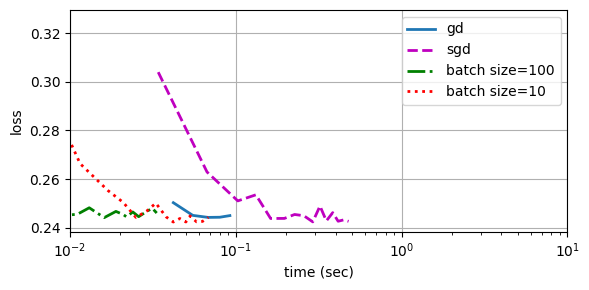

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def set_figsize(figsize=(3.5, 2.5)):
    """设置图表大小"""
    plt.rcParams['figure.figsize'] = figsize

def plot(X, Y, xlabel=None, ylabel=None, xlim=None, ylim=None, 
         xscale='linear', yscale='linear', legend=None, fmts=None):
    """
    绘制数据点
    
    参数:
    - X: x轴数据，可以是多个序列的列表
    - Y: y轴数据，可以是多个序列的列表
    - xlabel: x轴标签
    - ylabel: y轴标签
    - xlim: x轴范围
    - ylim: y轴范围
    - xscale: x轴比例 ('linear' 或 'log')
    - yscale: y轴比例 ('linear' 或 'log')
    - legend: 图例标签列表
    - fmts: 线条格式列表
    """
    if fmts is None:
        fmts = ['-', 'm--', 'g-.', 'r:']
    
    # 确保X和Y是列表形式
    if not isinstance(X, list):
        X = [X]
    if not isinstance(Y, list):
        Y = [Y]
        
    # 如果只有一个数据系列，确保fmts至少有一个元素
    if len(fmts) < len(Y):
        # 扩展fmts到足够的长度
        fmts = (fmts * ((len(Y) // len(fmts)) + 1))[:len(Y)]
    
    set_figsize()
    plt.gca().clear()  # 清除当前图形
    
    for x, y, fmt in zip(X, Y, fmts):
        plt.plot(x, y, fmt, linewidth=2)
    
    # 设置坐标轴标签
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
        
    # 设置坐标轴范围
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
        
    # 设置坐标轴比例
    if xscale:
        plt.xscale(xscale)
    if yscale:
        plt.yscale(yscale)
        
    # 添加图例
    if legend:
        plt.legend(legend)
        
    # 添加网格
    plt.grid(True)

# 使用示例（假设有gd_res, sgd_res, mini1_res, mini2_res这些数据）
# plot(list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
#      xlabel='time (sec)', ylabel='loss',
#      xlim=[1e-2, 10], legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
# plt.gca().set_xscale('log')
# plt.show()

# 如果你需要完全替代上面的调用方式，可以使用以下函数：
def compare_optimizers(gd_res, sgd_res, mini1_res, mini2_res):
    """
    比较不同优化器的性能
    
    参数:
    - gd_res: 批量梯度下降结果 (time_list, loss_list)
    - sgd_res: 随机梯度下降结果 (time_list, loss_list)
    - mini1_res: 小批量1结果 (time_list, loss_list)
    - mini2_res: 小批量2结果 (time_list, loss_list)
    """
    set_figsize([6, 3])
    
    # 解包结果数据
    gd_time, gd_loss = gd_res
    sgd_time, sgd_loss = sgd_res
    mini1_time, mini1_loss = mini1_res
    mini2_time, mini2_loss = mini2_res
    
    # 绘制四条曲线
    plt.figure(figsize=(6, 3))
    plt.plot(gd_time, gd_loss, '-', linewidth=2, label='gd')
    plt.plot(sgd_time, sgd_loss, 'm--', linewidth=2, label='sgd')
    plt.plot(mini1_time, mini1_loss, 'g-.', linewidth=2, label='batch size=100')
    plt.plot(mini2_time, mini2_loss, 'r:', linewidth=2, label='batch size=10')
    
    # 设置坐标轴
    plt.xlabel('time (sec)')
    plt.ylabel('loss')
    plt.xlim([1e-2, 10])
    plt.xscale('log')
    plt.legend()
    plt.grid(True)
    
    # 显示图表
    plt.tight_layout()
    plt.show()

compare_optimizers(gd_res, sgd_res, mini1_res, mini2_res)

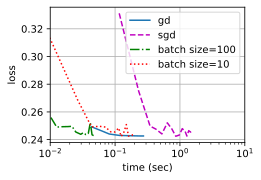

In [13]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
d2l.plt.gca().set_xscale('log')

## 简洁实现

下面用深度学习框架自带算法实现一个通用的训练函数，我们将在本章中其它小节使用它。


In [27]:
#@save
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # 初始化模型
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # MSELoss计算平方误差时不带系数1/2
                animator.add(n/X.shape[0]/len(data_iter),
                             (evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

下面使用这个训练函数，复现之前的实验。


loss: 0.243, 0.006 sec/epoch


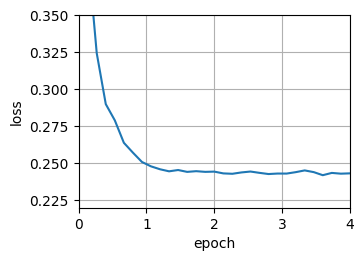

In [28]:
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

## 小结

* 由于减少了深度学习框架的额外开销，使用更好的内存定位以及CPU和GPU上的缓存，向量化使代码更加高效。
* 随机梯度下降的“统计效率”与大批量一次处理数据的“计算效率”之间存在权衡。小批量随机梯度下降提供了两全其美的答案：计算和统计效率。
* 在小批量随机梯度下降中，我们处理通过训练数据的随机排列获得的批量数据（即每个观测值只处理一次，但按随机顺序）。
* 在训练期间降低学习率有助于训练。
* 一般来说，小批量随机梯度下降比随机梯度下降和梯度下降的速度快，收敛风险较小。

## 练习

1. 修改批量大小和学习率，并观察目标函数值的下降率以及每个迭代轮数消耗的时间。
1. 将小批量随机梯度下降与实际从训练集中*取样替换*的变体进行比较。会看出什么？
1. 一个邪恶的精灵在没通知你的情况下复制了你的数据集（即每个观测发生两次，数据集增加到原始大小的两倍，但没有人告诉你）。随机梯度下降、小批量随机梯度下降和梯度下降的表现将如何变化？


[Discussions](https://discuss.d2l.ai/t/4325)
